In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('..')
from gstatsMCMC.gpu import Topography_gpu, MCMC_gpu
from gstatsMCMC import MCMC, Topography
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg

In [2]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [3]:
print(device)
def to_tensor(arr, device=device):
    # Using float64 to match NumPy's default precision for accurate comparison
    return torch.tensor(arr, dtype=torch.float32, device=device)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy()


mps


In [4]:
def get_mass_conservation_residual_torch(bed, surf, velx, vely, dhdt, smb, resolution):    

    thick_t = surf - bed

    # torch.gradient returns a list; axis 1 = x (columns), axis 0 = y (rows)
    (dx_t,) = torch.gradient(velx * thick_t, spacing=resolution, dim=1)
    (dy_t,) = torch.gradient(vely * thick_t, spacing=resolution, dim=0)

    res_t = dx_t + dy_t + dhdt - smb
    return res_t

def get_mass_conservation_residual_numpy(bed, surf, velx, vely, dhdt, smb, resolution):
    thick = surf - bed
    
    dx = np.gradient(velx*thick, resolution, axis=1)
    dy = np.gradient(vely*thick, resolution, axis=0)
    
    res = dx + dy + dhdt - smb
    
    return res

In [5]:
# --- 3. Create Mock Data (Synthetic Glacier Dome) ---
def generate_mock_data():
    ny, nx = 50, 50
    resolution = 100.0  # 100 meters per pixel

    # Create coordinate grid
    x = np.linspace(-nx//2 * resolution, nx//2 * resolution, nx)
    y = np.linspace(-ny//2 * resolution, ny//2 * resolution, ny)
    xv, yv = np.meshgrid(x, y)

    # 1. Bed: Flat subglacial topography at sea level
    bed = np.zeros((ny, nx))

    # 2. Surface: A simple parabolic ice dome
    # H = H0 - c * (x^2 + y^2)
    max_height = 2000.0
    surf = max_height - 0.0001 * (xv**2 + yv**2)
    surf = np.maximum(surf, 0) # Ice thickness cannot be negative

    # 3. Velocities: Flowing outward from the center (linearly increasing)
    velx = 0.05 * xv
    vely = 0.05 * yv

    # 4. dh/dt: Assume the glacier is thinning slightly everywhere
    dhdt = np.full((ny, nx), -0.5)

    # 5. SMB: Assume uniform accumulation
    smb = np.full((ny, nx), 0.3)

    return bed, surf, velx, vely, dhdt, smb, resolution

bed, surf, velx, vely, dhdt, smb, resolution = generate_mock_data()
bed_t, surf_t, velx_t, vely_t, dhdt_t, smb_t, res_val = [to_tensor(x) for x in generate_mock_data()]
print(type(bed), type(bed_t))

<class 'numpy.ndarray'> <class 'torch.Tensor'>


In [6]:
import timeit

# Define a wrapper for NumPy
def test_np():
    return get_mass_conservation_residual_numpy(bed, surf, velx, vely, dhdt, smb, resolution)

# Define a wrapper for Torch (with synchronization)
def test_torch():
    res = get_mass_conservation_residual_torch(bed_t, surf_t, velx_t, vely_t, dhdt_t, smb_t, res_val)
    if torch.cuda.is_available(): torch.cuda.synchronize()
    return res

# Run 100 iterations each
np_time = timeit.timeit(test_np, number=100)
torch_time = timeit.timeit(test_torch, number=100)

print(f"NumPy avg: {np_time/100:.6f}s")
print(f"Torch avg: {torch_time/100:.6f}s")

NumPy avg: 0.000034s
Torch avg: 0.002509s


In [7]:
df = pd.read_csv('../data/BindSchalder_Macayeal_IceStreams.csv')
df.head(5)

,x,y,surf,bed,velx,vely,smb,dhdt,highvel_mask,bedmap_mask,bedmap_surf,bedmachine_source,bedmachine_thickness,bedmap_bed
0,-997250,-1056750,1995.0,NaN,3.154910,3.089999,0.188461,0.015527,False,1.0,1995.0,5.0,2013.206726,-68.0
1,-996750,-1056750,1991.0,NaN,2.865254,2.668077,0.187869,0.015527,False,1.0,1991.0,5.0,2003.393005,-65.0
2,-996250,-1056750,1989.0,NaN,3.341836,3.024601,0.187278,0.015527,False,1.0,1989.0,5.0,1992.894836,-60.0
3,-995750,-1056750,1988.0,NaN,3.897542,3.608380,0.186686,0.015527,False,1.0,1988.0,5.0,1983.685974,-54.0
4,-995250,-1056750,1987.0,NaN,3.632191,3.761807,0.186094,0.014805,False,1.0,1987.0,5.0,1974.599670,-49.0


In [8]:
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [9]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

In [10]:
bedmachine_bed = bedmap_surf - bedmachine_thickness

In [11]:
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

(np.float64(-997500.0),
 np.float64(-408500.0),
 np.float64(-1057000.0),
 np.float64(-550500.0))

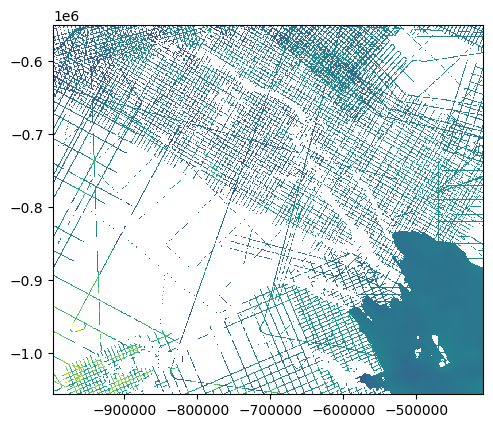

In [12]:
plt.pcolormesh(xx,yy,cond_bed)
plt.axis('scaled')

In [13]:
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

In [14]:
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

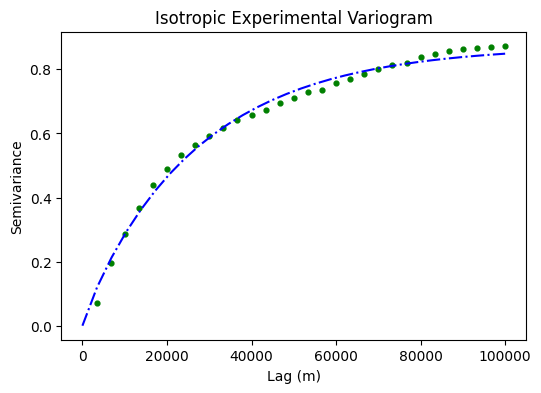

In [15]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.10, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 100000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [16]:
V1_p

[np.float64(78429.65327356523),
 np.float64(0.873808605331857),
 np.float64(0.4502273830750219),
 0]

In [17]:
sgs_bed = np.loadtxt('../sgs_beds/sgs_0_bindshadler_macayeal.txt')
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

In [18]:
grounded_ice_mask = (bedmap_mask == 1)

In [19]:
largeScaleChain = MCMC_gpu.chain_crf(xx, yy, sgs_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)
#cur_initial_bed_np = largeScaleChain.initial_bed.cpu().numpy()

before running the chain, please set where the block update will be using the object's function set_update_region(update_in_region, region_mask)
then please set up the loss function using either set_loss_type or set_loss_func
an RandField object also need to be created correctly and passed in set_crf_data_weight(RF) and in run(n_iter, RF)


In [20]:
type(largeScaleChain.initial_bed)

numpy.ndarray

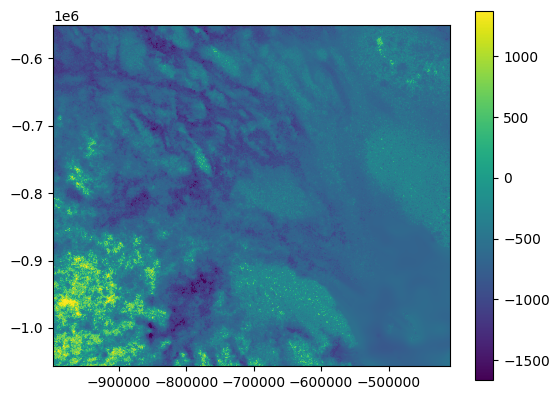

In [21]:

plt.pcolormesh(xx, yy, largeScaleChain.initial_bed)
plt.axis('scaled')
plt.colorbar()

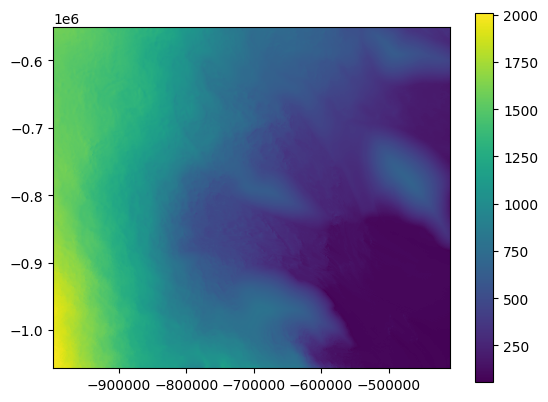

In [22]:
plt.pcolormesh(xx, yy, largeScaleChain.surf)
plt.axis('scaled')
plt.colorbar()

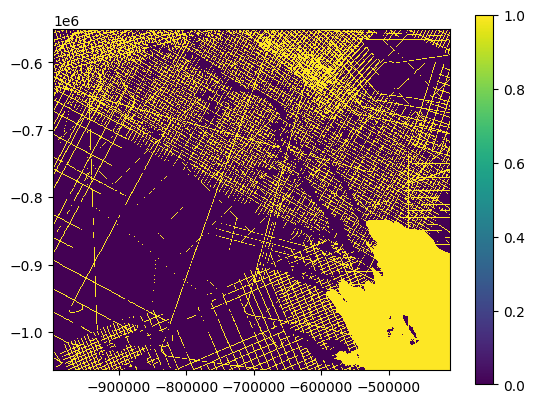

In [23]:
plt.pcolormesh(xx, yy, largeScaleChain.data_mask)
plt.axis('scaled')
plt.colorbar()

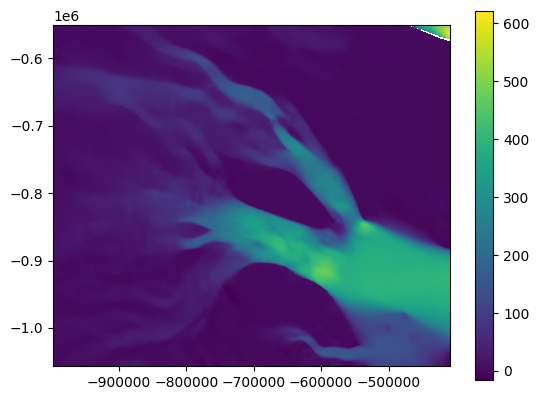

In [24]:
plt.pcolormesh(xx, yy, largeScaleChain.velx)
plt.axis('scaled')
plt.colorbar()

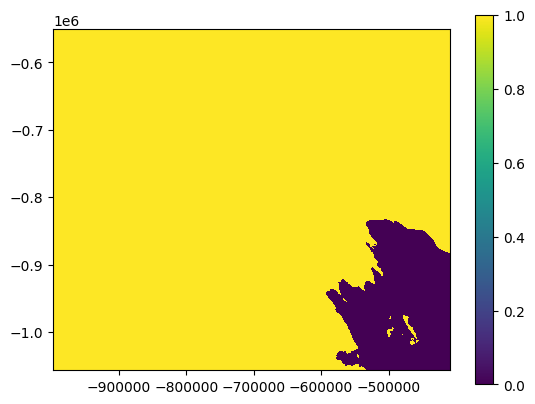

In [25]:
plt.pcolormesh(xx, yy, largeScaleChain.grounded_ice_mask)
plt.axis('scaled')
plt.colorbar()

In [26]:
largeScaleChain.set_update_region(True,highvel_mask)


the update blocks is set to be randomly generated for any locations inside the given region


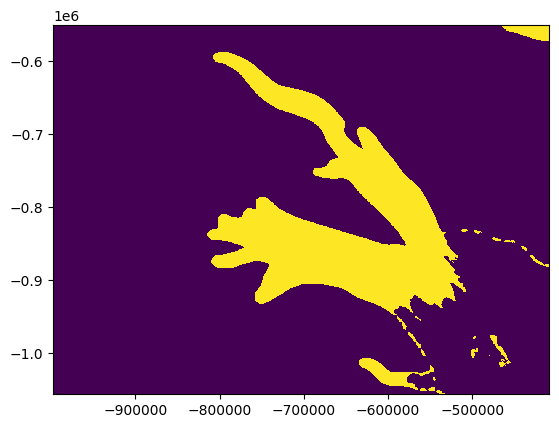

In [27]:
plt.pcolormesh(xx,yy,highvel_mask)

In [28]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version (PyTorch): {torch.version.cuda}")


PyTorch Version: 2.10.0
CUDA Version (PyTorch): None


In [29]:
mc_res_bm = Topography_gpu.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

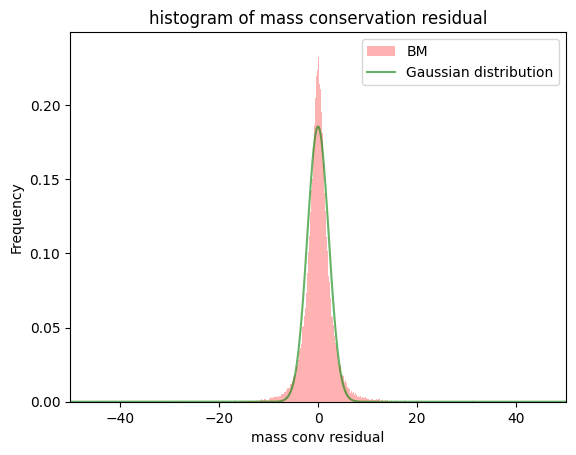

In [30]:
import config
sigma3 = config.sigma3
xl3=np.linspace(-100, 100, num=1000)
gaussian_model=1/(sigma3*np.sqrt(2*np.pi))*np.exp(-0.5*np.square(xl3/sigma3))

# here, we filter mc_res_bm to only account for mass flux residuals inside the high velocity region
mc_res_bm_sr2 = mc_res_bm[highvel_mask==1]
mc_res_bm_sr2_f = mc_res_bm_sr2.flatten()
mc_res_bm_sr2_f = mc_res_bm_sr2_f[~np.isnan(mc_res_bm_sr2_f)]

plt.hist(mc_res_bm_sr2_f, bins=5000, facecolor='red', alpha=0.3,density=True,label='BM')
plt.plot(xl3, gaussian_model, color='Green',alpha=0.6, label='Gaussian distribution')
plt.xlim([-50,50]);

plt.legend()
plt.xlabel('mass conv residual');
plt.ylabel('Frequency');
plt.title('histogram of mass conservation residual')
plt.show()

In [31]:
largeScaleChain.set_loss_type(sigma_mc=config.sigma3, massConvInRegion=True)
largeScaleChain.loss(mc_res_bm, 0)
#range_max and range_min changes topographies features' lateral scale
#by default, I set range_max to variogram range
range_max_x = 50e3 #in terms of meters in lateral dimension, regardless of resolution of the map
range_max_y = 50e3
range_min_x = 10e3
range_min_y = 10e3
scale_min = 50 #in terms of meters in vertical dimension, how much you want to multiply the perturbation by
scale_max = 150
nugget_max = 0
random_field_model = 'Matern' # currently only supporting 'Gaussian' or 'Exponential'
isotropic = True
smoothness = V1_p[2]

rf1 = MCMC_gpu.RandField(range_min_x, range_max_x, range_min_y, range_max_y, scale_min, scale_max, nugget_max, random_field_model, isotropic, smoothness = smoothness)
min_block_x = 50
max_block_x = 80
min_block_y = 50
max_block_y = 80
rf1.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)


Before using the `RandField` object in an MCMC chain or for field generation, 
 call function `set_block_sizes` to initialize block size ranges; 
 call function `set_weight_param` to set up conditional weighting parameters; 
 call function 'set_generation_method' to set up method used to generate random fields.


In [32]:
logis_func_L = 2
logis_func_x0 = 0
logis_func_k = 6
logis_func_offset = 1
max_dist = V1_p[0] # set to the distance between two points on the map where the correlation vanish / is minimal

rf1.set_weight_param(logis_func_L, logis_func_x0, logis_func_k, logis_func_offset, max_dist, resolution)
rf1.set_generation_method(spectral=True)

largeScaleChain.crf_data_weight = np.loadtxt('../data/data_weight.txt')
largeScaleChain.set_update_type('CRF_weight')
rng_seed = 23198104
largeScaleChain.set_random_generator(rng_seed = rng_seed)

The update block is set to conditional random field generated by calculating weights with logistic function


In [ ]:
n_iter = 10000
n_segment = 5

beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used = largeScaleChain.run_torch(n_iter=n_iter, RF=rf1, only_save_last_bed=True, progress_bar=True)


TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.